# Multiobjective Capacitataed Vehicle Routing Problems(MO-CVRP)

### **Multi-Objective** optimization, what's the difference ?
&nbsp;&nbsp;&nbsp;&nbsp; In a single objective optimization, there is only one objective function, so all the operations are directed approximating toward the minimum or maximum point. However, when it comes to multi-objective optimization, cases are always that the objective functions are conflicting, hardly can one single solution optimize every objective simultaneously. Hence, a balance among objective functions is needed. In theoretical terms, a solution is called nondominated, if one of the objective functions can not be improved except for degrading other objective values.

### Mathmatical definition of Multi-Objective optimization
&nbsp;&nbsp;&nbsp;&nbsp; In mathematical terms, a multi-objective optimization problem can be formulated as:
$$
\min_{x \in X}(f_{1}(x),f_{2}(x),...,f_{k}(x))
$$
where $k$ denote the number of objectives, $X$ denote feasible solution set.

&nbsp;&nbsp;&nbsp;&nbsp; In single minimum optimization, a solution is better than another when its ojbective function has smaller value. The same applies to multi-objective optimization, with a little difference.  
&nbsp;&nbsp;&nbsp;&nbsp; In multi-objective optimization, a feasible solution $x_{1} \in X$ is said to (Pareto) dominate another solution $x_{2} \in X$, if:
1. $\forall i \in {1,...,k}, f_{i}(x_{1}) \leq f_{i}(x_{2})$
2. $ \exists i \in {1,...,k}, f_{i}(x_{1}) < f_{i}(x_{2}) $  

&nbsp;&nbsp;&nbsp;&nbsp; A solution $x^* \in X$ (and the corresponding outcome $f(x^*)$)  is called Pareto optimal if there does not exist another solution that dominates it. The set of Pareto optimal outcomes, denoted $X^*$, is often called the **Pareto front**, Pareto frontier, or Pareto boundary.  
<div align="center">
  <img src="../Definitions/Pictures/Pareto dominance.jpg" alt="Centered Image" width="400">
  <figcaption>Pareto Dominance Illustration</figcaption>
</div>  

Natually, the goal of multi-objective optimization is to find a Pareto front consist of  multiple nondominated solutions.

# Non-dominated Sorting based algorithm
### Alogirhtm Introduction
The procedure of NSGA-II, a Non-dominated Sorting based algorithm, is shown as below:
<div align="center">
  <img src="../Definitions/Pictures/Algorithm-for-NSGA-II.png" alt="Centered Image" width="400">
  <figcaption>Algorithm-for-NSGA-II</figcaption>
</div>  


### Non-dominated Sorting
&nbsp;&nbsp;&nbsp;&nbsp; Given a population that contains multiple feasible solutions, non-dominated sorting classify them into different ranks.  
&nbsp;&nbsp;&nbsp;&nbsp; The process of non-dominated sorting begins with assigning the firrst rank to the non-dominated members of the initial population. These first ranked members are then placed in the first front and removed from the initial population. After that, the non-dominating sorting procedure is performed on the remaining population members. Further, the non-dominated members of the remaining population are assigned the second rank and placed in the second front. This process continues until the whole population members are put on different fronts according to their ranks, as shown below:  

<div align="center">
  <img src="../Definitions/Pictures/non-dominated sorting.jpg" alt="Centered Image" width="400">
  <figcaption>Non-dominated sorting and Crowding distance</figcaption>
</div>  
&nbsp;&nbsp;&nbsp;&nbsp; To ensure that the solutions on the pareto front are spreaded out(which is neccessary since more dispersed points represent a wider range of trade-offs among the objective functions), the concept of Crowding distance is introduced.

### Crowding distance
&nbsp;&nbsp;&nbsp;&nbsp; The crowding distance is calculated to quantify how close a solution is to its neighbors in the objective space, it can be formulated as:
$$
cd_{i} = \sum_{i=1}^{k} \frac{f_{j}^{i+1}-f_{j}^{i-1}}{f_{j}^{max}-f_{j}^{min}}
$$
where $k$ is the number of the objective funcions.  
&nbsp;&nbsp;&nbsp;&nbsp; Also, Solutions at the edges of the front are assigned an infinite crowding distance because they have no neighbors on one side.
Given a couple of non-dominated solutions, solutions with higer crowding distances are preferred since they preserve a more diverse pareto front.  

### Local Search
&nbsp;&nbsp;&nbsp;&nbsp; While NSGA-II has proven to be highly effective, I propose utilizing **Local search** to update solutions instead of genetic operators like crossover or mutation. This is motivated by the observation that encoding solutions for the Capacitated Vehicle Routing Problem (CVRP) within the genetic algorithm framework introduces unnecessary complexity to the problem. Consequently, local search offers a more straightforward and potentially more efficient approach for this particular problem.

In [214]:
import random
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt

In [215]:
#  Distance of a specific route.
def node_distance(A,B):
    return math.sqrt((A.x-B.x)**2 + (A.y-B.y)**2)
#  Calculate the distance matrix of all nodes
def distance_matrix(Nodes):
    n = len(Nodes)
    matrix = [[0 for i in range(n)] for j in range(n)]
    for i in range(n):
        for j in range(n):
            matrix[i][j] = node_distance(Nodes[i],Nodes[j])
    return matrix

1. Define class Node, Vehicle and RoutePlan(Vehicle fleet)

In [216]:
class Node():
    def __init__(self,id,x,y,pickup):
        self.id = id
        self.x = x
        self.y = y
        self.pickup = pickup

class Vehicle():
    def __init__(self,depot,capacity):
        self.depot = depot
        self.load = []
        self.capacity = capacity
        self.route = []

    def current_node(self):
        if self.route == []:
            return self.depot
        return self.route[-1]
    
    def add_node(self,node):
        if self.route == []:
            load = node.pickup
        else:
            load = node.pickup + self.load[-1]
        self.load.append(load)
        self.route.append(node)

    def route_length(self):
        length = 0
        for i in range(len(self.route)-1):
            length += node_distance(self.route[i],self.route[i+1])
        return length
    
    def update(self):
        self.load.append(self.route[0].pickup)
        for i,node in enumerate(self.route):
            if i == 0:
                continue
            self.load.append(node.pickup + self.load[-1])
        return
    
class RoutePlan():
    def __init__(self,depot,capacity):
        self.depot = depot
        self.capacity = capacity
        self.vehicles = []
        self.rank = None
        self.crowding_distance = None
        self.domination_count = None
        self.dominated_solutions = None

    def add_vehicle(self,vehicle):
        self.vehicles.append(vehicle)
    
    def update(self):
        self.vehicles = [vehicle for vehicle in self.vehicles if vehicle.route != []]
    
    def objectives(self):
        return np.array([self.f1(),self.f2(),self.f3()])

    def f1(self): # number of vehicles
        return len(self.vehicles)
    
    def f2(self): # Total Travel Distance
        total_distance = 0
        for vehicle in self.vehicles:
            total_distance += vehicle.route_length()
        return total_distance
    
    def f3(self): # The longest route
        makespan = 0
        for vehicle in self.vehicles:
            if vehicle.route_length() > makespan:
                makespan = vehicle.route_length()
        return makespan

    def dominate(self,RP):
        compare = self.objectives() <= RP.objectives()
        if compare.all() == True:
            return True
        return False

2. Generate Nodes and Initial solution

In [217]:
def Generate_Nodes(N):
    # Generate N nodes with random x,y coordinates and pickups
    Nodes = []
    location = list(set((random.randrange(800), random.randrange(400))for _ in range(N)))
    Pickups = list(random.randrange(10,40) for _ in range(N))
    for i in range(N):
        node = Node(i+1,location[i][0],location[i][1],Pickups[i])
        Nodes.append(node)
    return Nodes

def Initial_Solution(Nodes,capacity,N):
    population = []
    for i in range(N):
        RP = RoutePlan(Nodes[0],capacity)
        unvisited = list(range(1,len(Nodes)))

        vehicle = Vehicle(Nodes[0],capacity)
        while unvisited:
            current_node = vehicle.current_node()
        # Find the next node that satisfies the capacity and time windows constraints
            feasible_nodes = []
            load = vehicle.load[-1] if vehicle.load else 0
            for i in unvisited:
                if load + Nodes[i].pickup <= vehicle.capacity:
                    feasible_nodes.append(i)
            if feasible_nodes:
                if len(vehicle.route) == 0:
                    next_node = random.choice(feasible_nodes)
                else:
                    next_node = min(feasible_nodes,key=lambda x:node_distance(current_node,Nodes[x]))
                vehicle.add_node(Nodes[next_node])
                unvisited.remove(next_node)
            else:
                RP.add_vehicle(vehicle)
                if unvisited:
                    vehicle = Vehicle(Nodes[0],capacity)
        RP.add_vehicle(vehicle)
        population.append(RP)
    return population

3. Non-dominated sort and Pareto Front

In [218]:
def fast_non_dominated_sort(population):
    fronts = [[]]
    for RP in population:
        RP.domination_count = 0
        RP.dominated_solutions = []

        for other_RP in population:
            if RP == other_RP:
                continue
            if RP.dominate(other_RP):
                RP.dominated_solutions.append(other_RP)
            elif other_RP.dominate(RP):
                RP.domination_count += 1

        if RP.domination_count == 0:
            RP.rank = 0
            fronts[0].append(RP)

    i = 0
    while len(fronts[i]) > 0:
        next_front = []
        for RP in fronts[i]:
            for other_RP in RP.dominated_solutions:
                other_RP.domination_count -= 1

                if other_RP.domination_count == 0:
                    other_RP.rank = i+1
                    next_front.append(other_RP)
        fronts.append(next_front)
        i += 1
    fronts.pop() # remove the last empty front
    return fronts

def crowding_distance(front): # single front
    if len(front) > 0:
        for RP in front:
            RP.crowding_distance = 0

        for i in range(len(front[0].objectives())):
            front.sort(key = lambda RP: RP.objectives()[i])
            front[0].crowding_distance = front[-1].crowding_distance = float('inf')
            m_values = [RP.objectives()[i] for RP in front]
            scale = max(m_values) - min(m_values)
            if scale == 0: # in case all the values are the same
                scale = 1
            for j in range(1,len(front)-1):
                front[j].crowding_distance += (m_values[j+1] - m_values[j-1])/scale  ###########
    return


def surpass(RP1,RP2): #return better RP between two
    if RP1.rank < RP2.rank or \
    (RP1.rank == RP2.rank) and (RP1.crowding_distance > RP2.crowding_distance):
        return RP1
    return RP2

def next_gen(population,N):
    new_population = []
    # Constructing the Pareto Fronts
    fronts = fast_non_dominated_sort(population)

    k = 0
    while len(new_population) + len(fronts[k]) <= N:
        new_population += fronts[k]
        k += 1
    crowding_distance(fronts[k])
    fronts[k].sort(key = lambda RP: RP.crowding_distance,reverse=True)
    new_population += fronts[k][:N-len(new_population)]
    
    return new_population

4. Perturbation Functions

In [219]:
def insertion(RoutePlan):
    RP = copy.deepcopy(RoutePlan)
    # 1.  Select a node to remove
    #from_vehicle = min(RP.vehicles, key = lambda x : len(x.route)) # vehicle with the least nodes
    from_vehicle = random.choice(RP.vehicles)
    i = random.randint(0,len(from_vehicle.route)-1)
    node = from_vehicle.route.pop(i)

    # 2. Find the set of nodes that can be inserted to
    to_node_set = []
    for vehicle in RP.vehicles: #Do not insert to the same vehicle
        if vehicle == from_vehicle or vehicle.load[-1] + node.pickup > vehicle.capacity: # capacity constraint
            continue
        for n in vehicle.route:
            to_node_set.append(n)

    # If there is no feasible node to insert to, insert it back to the original vehicle
    if not to_node_set:
        from_vehicle.route.insert(i,node)
        return RP
    
    from_vehicle.update()
    # 3. Insert the removed node to a feasible position
    to_node = random.choice(to_node_set)
    for vehicle in RP.vehicles:
        if to_node.id in [node.id for node in vehicle.route]:
            to_vehicle = vehicle
            break
    j = to_vehicle.route.index(to_node)
    to_vehicle.route.insert(j,node)

    # 4.Update RoutePlan
    to_vehicle.update()
    RP.update()
    return RP

def two_optswap(Routeplan):
    RP = copy.deepcopy(Routeplan)
    for vehicle in RP.vehicles:
        route,load = vehicle.route,vehicle.load
        if len(route) > 4:
            i = random.randint(0,len(route)-2)
            j = random.randint(i+1,len(route)-1)
            B,C = route[i],route[j]
            A = route[i-1] if i != 0 else RP.depot
            D = route[j+1] if j != len(route)-1 else RP.depot
            if node_distance(A,C) + node_distance(B,D) < node_distance(A,B) + node_distance(C,D):
                vehicle.route[i:j+1] = reversed(vehicle.route[i:j+1])
                vehicle.update()
            if load[-1] > vehicle.capacity:
                vehicle.route[i:j+1] = reversed(vehicle.route[i:j+1])
                vehicle.update()
            else:
                continue
    return RP

def Reverse(Routeplan):
    RP = copy.deepcopy(Routeplan)
    for i in range(len(RP.vehicles)):
        vehicle = RP.vehicles[i]
        route = vehicle.route.copy() #Use shallow copy since route is not nested list
        if len(route) >= 4:
            i = random.randint(0, len(route)-2)
            j = random.randint(i+1, len(route)-1)
            route[i:j+1] = reversed(route[i:j+1])
            vehicle.route = route
            vehicle.update()
            if all([load < vehicle.capacity for load in vehicle.load[i:j+1]]):
                continue
            else:
                route[i:j+1] = reversed(route[i:j+1])# reverse back if not feasible
                vehicle.route = route
                vehicle.update()
    return RP

def perturbation(RP):
    #perturbation_func = random.choice([insertion,Reverse])
    RP = insertion(RP)
    RP = two_optswap(RP)
    RP = Reverse(RP)
    return RP

def show_result(front):
    df = pd.DataFrame(columns = ['Number of Vehicles','Total Travel Distance','Makespan'])
    for i,RP in enumerate(front):
        df.loc[i] = RP.objectives()
    return df

def PlotRoute(RP):
    plt.figure()
    depot = RP.depot
    plt.plot(depot.x,depot.y,'r,',markersize=20)
    for vehicle in RP.vehicles:
        route = [(depot.x,depot.y)] + [(node.x,node.y) for node in vehicle.route] + [(depot.x,depot.y)]
        plt.plot(*zip(*route),'-o')
    plt.show()
    return 

5. Main Function

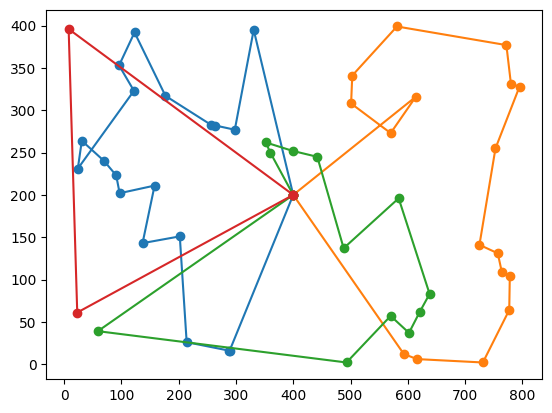

   Number of Vehicles  Total Travel Distance     Makespan
0                 4.0            3568.465396  1092.882162
1                 4.0            3285.664336  1165.146212
2                 4.0            3143.247051  1201.169977
3                 4.0            3004.422092  1225.528462


In [220]:
# 1. Generate N nodes, a depot and the initial solution
capacity = 400
depot = Node(0,400,200,0)
N = 50
customers = Generate_Nodes(N)
Nodes = [depot] + customers
dist_matrix = distance_matrix(Nodes)

# 2. Evolution
pop_size = 50
population = Initial_Solution(Nodes,capacity,N)
max_iter = 50

for i in range(max_iter):
    new_pop = []
    for RP in population:
        new_RP = perturbation(RP)
        new_pop.append(new_RP)
    population.extend(new_pop)
    
    population = next_gen(population,N)
# Get the final Pareto Fronts
fronts = fast_non_dominated_sort(population)
for front in fronts:
    crowding_distance(front)

# 3. Visualization
PlotRoute(fronts[0][0])
result = show_result(fronts[0])
print(result)